# Nigeria Crude Oil Analysis
## By Goodrich Okoro

# Nigeria Export Crude Oil Production and Price
According to [Wikipedia](https://en.wikipedia.org/wiki/Petroleum_industry_in_Nigeria#:~:text=Nigeria%20is%20the%20largest%20oil,paraffinic%20and%20low%20in%20sulfur.), Nigeria is the largest oil and gas producer in Africa. [Crude oil](https://en.wikipedia.org/wiki/Petroleum) from the [Niger delta basin](https://en.wikipedia.org/wiki/Niger_Delta) comes in two types: [light](https://en.wikipedia.org/wiki/Light_crude_oil), and comparatively [heavy](https://en.wikipedia.org/wiki/Heavy_crude_oil) – the lighter has around 36 gravity while the heavier has 20–25 gravity. Both types are [paraffinic](https://en.wikipedia.org/wiki/Alkane) and low in [sulfur](https://en.wikipedia.org/wiki/Sulfur).Nigeria's economy and budget have been largely supported from income and revenues generated from the petroleum industry since 1960. Statistics as at February 2021 shows that the Nigerian oil sector contributes to about 9% of the entire [GDP](https://en.wikipedia.org/wiki/Gross_domestic_product) of the nation. Nigeria is the largest oil and gas producer in Africa, a major exporter of crude oil and petroleum products to the United States of America. In 2010, Nigeria exported over one million barrels per day to the United States of America, representing 9% of the U.S. total crude oil and petroleum products imports and over 40% of Nigeria exports.

<p><center><img src="https://cdn08.allafrica.com/download/pic/main/main/csiid/00410084:4f39f9cb5c0f3b30f3087c8a62f45009:arc614x376:w735:us1.jpg" alt></center></p>

This project involves the use of [**SQL**](https://www.w3schools.com/sql/) and [**Python**](https://www.python.org/) programming language. SQL will be used to answer the given question while Python will be used to present the answers as a dataframe and visualize it where necessary.

The data used for this analysis can be found on [Central Bank of Nigeria (CBN) Statistic section](https://www.cbn.gov.ng/rates/crudeoil.asp). It contain 5 fields with 201 records.

<h1 id="crude_oil"><code>CrudeOilPrice</code></h1>
<table>
<thead>
<tr>
<th>column</th>
<th>type</th>
<th>description</th>
</tr>
</thead>
<tbody>
<tr>
<td><code>year</code></td>
<td><code>varchar</code></td>
<td>Year of production</td>
</tr>
<tr>
<td><code>month</code></td>
<td><code>smallint</code></td>
<td>Month in each year</td>
</tr>
<tr>
<td><code>crude_oil_price</code></td>
<td><code>decimal</code></td>
<td>Price of crude oil (US$/Barrel)</td>
</tr>
<tr>
<td><code>production</code></td>
<td><code>decimal</code></td>
<td>Crude oil produced in millions barrels per day (mbd)</td>
</tr>
<tr>
<td><code>crude_oil_export</code></td>
<td><code>decimal</code></td>
<td>Crude oil exported in millions barrels per day (mbd)</td>
</tr>
</tbody>
</table>

## Questions 
* Which year was the largest production ever made? Narrow it down to the month.
* Which year has the highest average production of crude oil for our record?
* Which year has the highest average price?
* Is there a month where all barrels of oil produced was exported totally?
* How many times was crude oil exported less than 70% of the production total?
* How has production and price change with three years gap?

Other insights. 

In [1]:
# Importing required libraries
import sqlite3 as sq
import plotly.graph_objs as go
import plotly.offline as po
po.init_notebook_mode(connected=True)

In [2]:
# Creating Database
conn = sq.connect("crude_oil.db")

# Create a table called crudeOilPrice
query = """
CREATE TABLE crudeOilPrice(
    year VARCHAR(4),
    month SMALLINT,
    crude_oil_price DECIMAL(5,2),
    production DECIMAL(3,2),
    crude_oil_export DECIMAL(3,2)
    )"""

with conn:
    cur = conn.cursor()
    cur.execute("DROP TABLE IF EXISTS crudeOilPrice")
    cur.execute(query)

In [3]:
# checking our sqlite master for confirmation
query = "SELECT name FROM sqlite_master WHERE type='table'"
import pandas as pd
sqlDF = pd.read_sql_query(query, conn)
sqlDF

,name
0,crudeOilPrice


Let fill in values from the [csv file](https://www.cbn.gov.ng/Functions/export.asp?tablename=CrudeOilProdPrice) gotten from CBN


In [4]:
# Loading CSV file
csv = pd.read_csv('CrudeOilProdPrice25102022.csv', index_col=False)
csv.head()

,Year,Month,Crude Oil Price,Production,Crude Oil Export
0,2006,1,63.85,2.59,2.14
1,2006,2,61.33,2.47,2.02
2,2006,3,65.00,2.25,1.80
3,2006,4,72.09,2.32,1.87
4,2006,5,71.18,2.28,1.83


In [5]:
# creating a tuple of values in each row
csvTuple = tuple(csv.itertuples(index=False, name=None))
csvTuple[0]

# inserting into table crudeOilPrice
insertQuery = "INSERT INTO crudeOilPrice values(?,?,?,?,?)"
cur.executemany(insertQuery, csvTuple)

# Reading table as a pandas dataframe
query = "SELECT * FROM crudeOilPrice"
pd.read_sql_query(query, conn)


,year,month,crude_oil_price,production,crude_oil_export
0,2006,1,63.85,2.59,2.14
1,2006,2,61.33,2.47,2.02
2,2006,3,65.00,2.25,1.80
3,2006,4,72.09,2.32,1.87
4,2006,5,71.18,2.28,1.83
...,...,...,...,...,...
196,2022,5,116.72,1.02,0.57
197,2022,6,130.10,1.16,0.71
198,2022,7,120.54,1.08,0.63
199,2022,8,106.34,0.97,0.52


## Data Cleaning
In the data, moths were represented with numbers. This will be replaced with the actual month name.

In [6]:
# Replacing month numbers with actual name
query = """
UPDATE
    crudeOilPrice
SET 
    month = 
        REPLACE(
        REPLACE(
        REPLACE(
        REPLACE(
        REPLACE(
        REPLACE(
        REPLACE(
        REPLACE(
        REPLACE(
        REPLACE(
        REPLACE(
        REPLACE(month, 12, 'December'), 
        2, 'February'), 
        3, 'March'),
        4, 'April'),
        5, 'May'), 
        6, 'June'),
        7, 'July'),
        8, 'August'),
        9, 'September'),
        10, 'October'),
        11, 'November'),
        1, 'January')
"""
# Previewing for confirmation
cur.execute(query)
query = "SELECT * FROM crudeOilPrice"
pd.read_sql_query(query, conn)

,year,month,crude_oil_price,production,crude_oil_export
0,2006,January,63.85,2.59,2.14
1,2006,February,61.33,2.47,2.02
2,2006,March,65.00,2.25,1.80
3,2006,April,72.09,2.32,1.87
4,2006,May,71.18,2.28,1.83
...,...,...,...,...,...
196,2022,May,116.72,1.02,0.57
197,2022,June,130.10,1.16,0.71
198,2022,July,120.54,1.08,0.63
199,2022,August,106.34,0.97,0.52


## Exploration

In [7]:
# Overview of record
query = """
SELECT  COUNT(*) Records, 
        COUNT(DISTINCT year) Years_record,
        COUNT(DISTINCT month) Distinct_Month,
        MIN(year) AS Start_year,
        MAX(year) AS End_year
  FROM  crudeOilPrice
"""
sqlDF = pd.read_sql_query(query, conn)
sqlDF

,Records,Years_record,Distinct_Month,Start_year,End_year
0,201,17,12,2006,2022


### Which year was the largest production ever made? Narrow it down to the month.

In [8]:
query = """
SELECT  year, month, max(production) AS Max_Prod
  FROM  crudeOilPrice
"""
pd.read_sql_query(query, conn)

,year,month,Max_Prod
0,2010,October,2.88


The largest production was made in October 2010
### Which year has the highest average production of crude oil for our record?

In [9]:
query = """
SELECT sub.Year, max(sub.Avg_Prod) AS Max_Avg_Prod
  FROM (
          SELECT year AS Year, avg(production) AS Avg_Prod
            FROM crudeOilPrice
        GROUP BY Year) AS sub
"""
pd.read_sql_query(query, conn)

,Year,Max_Avg_Prod
0,2010,2.4675


 The highest average production was made in 2010
 ### Which year has the highest average price?

In [10]:
query = """
SELECT sub.Year, max(Avg_Price) AS Max_Avg_Price
  FROM (
          SELECT year AS Year, avg(crude_oil_price) AS Avg_Price
            FROM crudeOilPrice
        GROUP BY Year) AS sub
"""
pd.read_sql_query(query, conn)

,Year,Max_Avg_Price
0,2011,113.76


2011 has the highest average price
### Is there a month where all barrels of oil produced was exported totally?

In [11]:
query = """
SELECT COUNT(*) AS count
  FROM crudeOilPrice
 WHERE production = crude_oil_export
"""
pd.read_sql_query(query, conn)

,count
0,0


Nigeria has never exported all the crude oil it produce.
### How many times was crude oil exported less than 70% of the production total?

In [12]:
query = """
SELECT  COUNT(*) AS Count
  FROM  (
        SELECT production, year, crude_oil_export, 0.7 * production AS seventy_perc_prod
  FROM  crudeOilPrice)
 WHERE  crude_oil_export < seventy_perc_prod
"""
pd.read_sql_query(query, conn)

,Count
0,22


We have 22 count, let's narrow it down to year with the highest count.

In [13]:
query = """
  SELECT year AS Year, COUNT(*) AS Export_Count
    FROM (
           SELECT production, year, crude_oil_export, 0.7 * production AS fifty_perc_prod
             FROM crudeOilPrice)
   WHERE crude_oil_export < fifty_perc_prod
GROUP BY Year
"""
pd.read_sql_query(query, conn)

,Year,Export_Count
0,2020,1
1,2021,12
2,2022,9


We have seen years that exported oil was below 70% of production. 

Let's look at when exported oil was above 80%

In [14]:
# Extracting data
query = """
  SELECT year AS Year, COUNT(*) AS Export_Count
    FROM (
          SELECT production, year, crude_oil_export, 0.8 * production AS fifty_perc_prod
          FROM crudeOilPrice)
   WHERE crude_oil_export >= fifty_perc_prod
GROUP BY Year
"""
sqlDF = pd.read_sql_query(query, conn, index_col='Year')
print(sqlDF)

# Plotting viz
fig = go.Figure()
fig.add_trace(go.Scatter(x=sqlDF.index, y=sqlDF.Export_Count,
                            mode= 'lines+markers+text',
                            text= sqlDF.Export_Count, textposition='top center',
                            line=dict(color='forestgreen', 
                                        width=3, dash='dot'),
                            textfont=dict(size=13)))
fig.update_layout(title='Crude oil export above 80% of production', width=700)
fig.show("notebook_connected")

      Export_Count
Year              
2006            12
2007             5
2008             1
2009             1
2010            11
2011            12
2012             8
2013             2
2014             3


It turns out that the last time oil was exported above 80% of production was in 2014. 

And its only in 2006 and 2011 that 80% of produced oil was exported in all months.

### How has production and price change with three years gap?
**Price Difference**

In [15]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
month_short = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Extracting data
query = """
WITH first AS (
    SELECT  c1.month, c1.crude_oil_price AS Price2006, c2.crude_oil_price AS Price2009
      FROM  crudeOilPrice AS c1
INNER JOIN  crudeOilPrice AS c2
        ON  c1.month = c2.month
     WHERE  c1.year = 2006 AND c2.year = c1.year + 3),

sec AS (
    SELECT  c1.month, c1.crude_oil_price AS Price2012, c2.crude_oil_price AS Price2015
      FROM  crudeOilPrice AS c1
INNER JOIN  crudeOilPrice AS c2
        ON  c1.month = c2.month
     WHERE  c1.year = 2012 AND c2.year = c1.year + 3),

third AS (
    SELECT  c1.month, c1.crude_oil_price AS Price2018, c2.crude_oil_price AS Price2021
      FROM  crudeOilPrice AS c1
INNER JOIN  crudeOilPrice AS c2
        ON  c1.month = c2.month
     WHERE  c1.year = 2018 AND c2.year = c1.year + 3)
     
    SELECT  f.month, f.Price2006, f.Price2009, s.Price2012, s.Price2015, t.Price2018, t.Price2021
      FROM  first AS f
 LEFT JOIN  sec AS s
     USING  (month)
 LEFT JOIN  third AS t
     USING  (month)
"""

sqlDF = pd.read_sql_query(query, conn, index_col='month').reindex(month_order)
sqlDF

,Price2006,Price2009,Price2012,Price2015,Price2018,Price2021
month,,,,,,
January,63.85,44.95,113.81,48.81,69.68,54.87
February,61.33,46.52,121.87,58.09,66.67,62.48
March,65.00,49.70,128.00,56.69,74.72,65.62
April,72.09,51.16,122.62,57.45,72.37,64.30
May,71.18,60.02,113.08,65.08,77.64,67.83
June,69.32,72.24,98.06,62.06,75.38,73.46
July,75.13,66.52,104.62,57.01,74.72,75.93
August,75.15,74.00,113.76,47.09,73.35,70.72
September,62.97,70.22,114.36,48.08,79.59,74.55


In [16]:
# Plotting Data
def add_year(price_year, color):
    price = price_year
    name = price[5:] + ' Price'
    fig.add_trace(go.Scatter(x=sqlDF.index, y=sqlDF[price_year],
                            name=name, line=dict(color=color, 
                                                            width=3, dash='dot')))
fig = go.Figure()
add_year('Price2006', 'firebrick')
add_year('Price2009', 'royalblue')
add_year('Price2012', 'goldenrod')
add_year('Price2015', 'darkturquoise')
add_year('Price2018', 'forestgreen')
add_year('Price2021', 'darkgrey')
fig.update_layout(title='Crude oil price with three years gap', width=850,
                  yaxis_title = 'Price (US$/Barrel)',
                  xaxis = dict(
                      tickvals = month_order, 
                      ticktext = month_short
                  )
                  )
fig.show()

2012 looks like an ouliear but then, we are viewing the year with three years gap. The price is clustered between 35 and 85(US%/Barrel).

**Production Difference**

In [17]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

# Extracting Data
query = """
WITH first AS (
    SELECT  c1.month, c1.production AS Prod2006, c2.production AS Prod2009
      FROM  crudeOilPrice AS c1
INNER JOIN  crudeOilPrice AS c2
        ON  c1.month = c2.month
     WHERE  c1.year = 2006 AND c2.year = c1.year + 3),

sec AS (
    SELECT  c1.month, c1.production AS Prod2012, c2.production AS Prod2015
      FROM  crudeOilPrice AS c1
INNER JOIN  crudeOilPrice AS c2
        ON  c1.month = c2.month
     WHERE  c1.year = 2012 AND c2.year = c1.year + 3),

third AS (
    SELECT  c1.month, c1.production AS Prod2018, c2.production AS Prod2021
      FROM  crudeOilPrice AS c1
INNER JOIN  crudeOilPrice AS c2
        ON  c1.month = c2.month
     WHERE  c1.year = 2018 AND c2.year = c1.year + 3)
     
    SELECT  f.month, f.Prod2006, f.Prod2009, s.Prod2012, s.Prod2015, t.Prod2018, t.Prod2021
      FROM  first AS f
 LEFT JOIN  sec AS s
     USING  (month)
 LEFT JOIN  third AS t
     USING  (month)
"""

sqlDF = pd.read_sql_query(query, conn, index_col='month').reindex(month_order)
sqlDF

,Prod2006,Prod2009,Prod2012,Prod2015,Prod2018,Prod2021
month,,,,,,
January,2.59,2.03,2.23,2.20,2.00,1.36
February,2.47,2.06,2.40,2.21,2.01,1.42
March,2.25,2.07,2.34,2.07,1.94,1.43
April,2.32,1.86,2.30,2.03,1.97,1.37
May,2.28,2.22,2.40,2.05,1.78,1.34
June,2.41,2.17,2.37,1.97,1.78,1.31
July,2.39,2.14,2.42,2.18,1.83,1.32
August,2.40,2.12,2.48,2.12,2.00,1.24
September,2.40,2.18,2.45,2.22,1.96,1.25


In [18]:
# Plotting data
def add_year(price_year, color):
    price = price_year
    name = price[4:] + ' Production'
    fig.add_trace(go.Scatter(x=sqlDF.index, y=sqlDF[price_year],
                            name=name, line=dict(color=color, 
                                                            width=3, dash='dot')))
fig = go.Figure()
add_year('Prod2006', 'firebrick')
add_year('Prod2009', 'royalblue')
add_year('Prod2012', 'goldenrod')
add_year('Prod2015', 'darkturquoise')
add_year('Prod2018', 'forestgreen')
add_year('Prod2021', 'darkgrey')

fig.update_layout(title='Crude oil production with three years gap', width=850,
                  yaxis_title = 'Production (mbd)',
                  xaxis = dict(
                      tickvals = month_order, 
                      ticktext = month_short
                  )
                  )
fig.show()

From the visual above, production started decreasing after 2012. 

### Other Insights

* Summarizing the three numeric column

In [19]:
# Extracting Summary
query = """
SELECT  min(crude_oil_price) Min_Price,
        ROUND(avg(crude_oil_price), 2) Avg_Price,
        max(crude_oil_price) Max_Price,
        min(production) Min_Production,
        ROUND(avg(production), 2) Avg_Production,
        max(production) Max_Production,
        min(crude_oil_export) Min_Export,
        ROUND(avg(crude_oil_export), 2) Avg_Export,
        max(crude_oil_export) Max_Export
  FROM  crudeOilPrice
"""

pd.read_sql_query(query, conn)

,Min_Price,Avg_Price,Max_Price,Min_Production,Avg_Production,Max_Production,Min_Export,Avg_Export,Max_Export
0,14.28,78.17,138.74,0.94,2.03,2.88,0.49,1.58,2.43


**Statistics Summary Of Crude Oil**

**Price by month**

In [20]:
# Extracting data
query = """
  SELECT month Month,
         min(crude_oil_price) Min_Price,
         ROUND(avg(crude_oil_price), 2) Avg_Price,
         max(crude_oil_price) Max_Price
    FROM crudeOilPrice
GROUP BY month
ORDER BY Avg_Price
"""

sqlDF = pd.read_sql_query(query, conn, index_col='Month').reindex(month_order)
sqlDF

,Min_Price,Avg_Price,Max_Price
Month,,,
January,30.66,73.43,115.24
February,31.70,75.73,121.87
March,32.29,78.70,128.00
April,14.28,78.90,124.49
May,27.90,81.27,126.57
June,40.30,82.88,138.74
July,44.10,83.00,137.74
August,45.06,79.69,115.84
September,40.85,79.06,115.73


In [21]:
# Plotting data
def add_line(price, color):
    fig.add_trace(go.Scatter(x=sqlDF.index, y=sqlDF[price],
                            name=price, mode='lines+markers+text',
                            text = sqlDF[price], textposition='top center',
                            line=dict(color=color, 
                                      width=3, dash='dot'),
                            textfont=dict(
                                size=10
                            )))
fig = go.Figure()
add_line('Min_Price', 'firebrick')
add_line('Avg_Price', 'royalblue')
add_line('Max_Price', 'forestgreen')

fig.update_layout(title='Summary of crude oil price by month', width=850,
                  yaxis_title = 'Price (US$/Barrel)',
                  xaxis = dict(
                      tickvals = month_order, 
                      ticktext = month_short
                  ))
fig.update_yaxes(showticklabels=False)
fig.show()

From the plot above, we can see that average price of crude oil increase as the year starts and decrease towards the end.

**Price by year**

In [22]:
# Extracting data
query = """
  SELECT year Year,
         min(crude_oil_price) Min_Price,
         ROUND(avg(crude_oil_price), 2) Avg_Price,
         max(crude_oil_price) Max_Price
    FROM crudeOilPrice
GROUP BY year
ORDER BY Avg_Price
"""

sqlDF = pd.read_sql_query(query, conn, index_col='Year').sort_index()
sqlDF

,Min_Price,Avg_Price,Max_Price
Year,,,
2006,59.49,66.67,75.15
2007,55.57,74.96,95.05
2008,45.87,101.02,138.74
2009,44.95,63.90,78.25
2010,75.06,80.90,92.79
2011,97.96,113.76,124.49
2012,98.06,113.72,128.00
2013,105.55,110.99,118.81
2014,63.28,100.40,114.60


In [23]:
# Plotting Data
def add_line(price, color):
    fig.add_trace(go.Scatter(x=sqlDF.index, y=sqlDF[price],
                            name=price, line=dict(color=color, 
                                                    width=3, dash='dot')))
fig = go.Figure()
add_line('Min_Price', 'firebrick')
add_line('Avg_Price', 'royalblue')
add_line('Max_Price', 'forestgreen')

fig.update_layout(title='Summary of crude oil price by year', width=950,
                  yaxis_title = 'Price (US$/Barrel)'
                  )
fig.show()

**Production by month**

In [24]:
# Extracting Data
query = """
  SELECT month Month,
         min(production) Min_Production,
         ROUND(avg(production), 2) Avg_Production,
         max(production) Max_Production
    FROM crudeOilPrice
GROUP BY month
ORDER BY Avg_Production
"""

sqlDF = pd.read_sql_query(query, conn, index_col='Month').reindex(month_order)
sqlDF

,Min_Production,Avg_Production,Max_Production
Month,,,
January,1.36,2.10,2.59
February,1.26,2.10,2.51
March,1.24,2.02,2.44
April,1.22,2.01,2.42
May,1.02,1.98,2.50
June,1.16,1.97,2.41
July,1.08,2.01,2.48
August,0.97,2.02,2.50
September,0.94,2.02,2.48


In [25]:
# Plotting Data
def add_line(price, color):
    fig.add_trace(go.Scatter(x=sqlDF.index, y=sqlDF[price],
                            name=price, mode= 'lines+markers+text',
                            text= sqlDF[price], textposition='top center',
                            line=dict(color=color, 
                                      width=3, dash='dot'),
                            textfont=dict(
                                size=10
                            )))
fig = go.Figure()
add_line('Min_Production', 'firebrick')
add_line('Avg_Production', 'royalblue')
add_line('Max_Production', 'forestgreen')

fig.update_layout(title='Summary of crude oil production by month', width=850,
                  yaxis_title = 'Production (mbd)',
                  xaxis = dict(
                      tickvals = month_order, 
                      ticktext = month_short
                  ))
fig.update_yaxes(showticklabels=False)
fig.show()

**Production by year**

In [26]:
# Extracting data
query = """
  SELECT year Year,
         min(production) Min_Production,
         avg(production) Avg_Production,
         max(production) Max_Production
    FROM crudeOilPrice
GROUP BY year
ORDER BY Avg_Production
"""

sqlDF = pd.read_sql_query(query, conn, index_col='Year').sort_index()
sqlDF

,Min_Production,Avg_Production,Max_Production
Year,,,
2006,2.25,2.382500,2.59
2007,1.96,2.201667,2.32
2008,1.96,2.099167,2.26
2009,1.86,2.110833,2.28
2010,2.21,2.467500,2.88
2011,2.27,2.380833,2.51
2012,2.03,2.318333,2.48
2013,2.03,2.183333,2.29
2014,2.06,2.205833,2.33


In [27]:
# Plotting Data
def add_line(price, color):
    fig.add_trace(go.Scatter(x=sqlDF.index, y=sqlDF[price],
                            name=price, line=dict(color=color, 
                                                            width=3, dash='dot')))
fig = go.Figure()
add_line('Min_Production', 'firebrick')
add_line('Avg_Production', 'royalblue')
add_line('Max_Production', 'forestgreen')

fig.update_layout(title='Summary of crude oil production by year', width=950,
                  yaxis_title = 'Production (mbd)'
                  )
fig.show()

**Let's look at years that its average is above the overall average for price, production and export**

In [28]:
# Extracting Data
query = """
SELECT Year, Year_avg_export, sub.Overall_avg_export
  FROM (SELECT year Year, ROUND(avg(crude_oil_export), 2) Year_avg_export, 
               (SELECT ROUND(avg(crude_oil_export), 2) 
                  FROM crudeOilPrice) Overall_avg_export
          FROM crudeOilPrice
      GROUP BY year) sub
-- WHERE Year_avg_export > sub.Overall_avg_export
"""
sqlDF = pd.read_sql_query(query, conn, index_col='Year').sort_index()
sqlDF

,Year_avg_export,Overall_avg_export
Year,,
2006,1.93,1.58
2007,1.75,1.58
2008,1.65,1.58
2009,1.66,1.58
2010,2.02,1.58
2011,1.93,1.58
2012,1.87,1.58
2013,1.73,1.58
2014,1.76,1.58


In [29]:
# Plotting Data
fig = go.Figure()
fig.add_trace(go.Scatter(x=sqlDF.index, y=sqlDF.Year_avg_export,
                            name='Year_avg_export', mode= 'lines+markers+text',
                            text= sqlDF.Year_avg_export, textposition='top right',
                            line=dict(color='royalblue', 
                                        width=3, dash='dot'),
                            textfont=dict(size=11)))

fig.add_trace(go.Scatter(x=sqlDF.index, y=sqlDF.Overall_avg_export,
                            name='Overall_avg_export', line=dict(color='firebrick', 
                                                            width=3, dash='dot')))

fig.update_layout(title='Comparing yearly average of crude oil exported with overall average, 1.58mbd', width=950,
                  yaxis_title = 'Production (mbd)')
fig.update_yaxes(showticklabels=False)
fig.show()

Starting from 2016, the yearly average of crude oil exported has not pass the overall average of crude oil exported, And the gap is increasing. Do you think it will pass the mark in few years?

**Comparing 2021 crude oil production with 2022**

In [30]:
# Filtering monthly production
query = """
WITH sub AS (
    SELECT month, SUM(production) AS total_prod_2022
                            FROM crudeOilPrice
                           WHERE year = '2022'
                        GROUP BY month)

  SELECT c1.month, SUM(c1.production) AS total_prod_2021, sub.total_prod_2022
    FROM crudeOilPrice AS c1
    LEFT JOIN sub 
    USING(month)
   WHERE year = '2021' 
GROUP BY c1.month
"""
sqlDF = pd.read_sql_query(query, conn, index_col='month').reindex(month_order)
print(sqlDF)

           total_prod_2021  total_prod_2022
month                                      
January               1.36             1.40
February              1.42             1.26
March                 1.43             1.24
April                 1.37             1.22
May                   1.34             1.02
June                  1.31             1.16
July                  1.32             1.08
August                1.24             0.97
September             1.25             0.94
October               1.23              NaN
November              1.23              NaN
December              1.20              NaN


In [31]:
# Visualizing data
def add_line(total_prod, color):
    ex = total_prod
    name = ex[-4:] + ' Production'
    fig.add_trace(go.Scatter(x=sqlDF.index, y=sqlDF[total_prod],
                            name=name, mode='lines+markers+text',
                            text=sqlDF[total_prod], textposition='bottom left',
                            line=dict(color=color, 
                                        width=3, dash='dot'),
                            textfont=dict(size=10)))
fig = go.Figure()
add_line('total_prod_2021', 'royalblue')
add_line('total_prod_2022', 'firebrick')


fig.update_layout(title='Comparing year 2021 crude oil production with that of 2022', width=950,
                  yaxis_title = 'Production (mbd)',
                  xaxis= dict(
                      tickvals= month_order,
                      ticktext= month_short
                  ))
fig.update_yaxes(showticklabels=False)
fig.show()

The above charts depicts that production is decreasing. Will it increase next month? We don't know untill we have the data for that month.

**Change in production between 2021 and 2022**

In [32]:
# Filtering monthly production
query = """
WITH sub AS (
    SELECT month, SUM(production) AS total_prod_2022
                            FROM crudeOilPrice
                           WHERE year = '2022'
                        GROUP BY month)

  SELECT c1.month, SUM(c1.production) AS total_prod_2021, sub.total_prod_2022,
            ROUND((sub.total_prod_2022 - SUM(c1.production)) * 100) Percentage_change
    FROM crudeOilPrice AS c1
    LEFT JOIN sub 
    USING(month)
   WHERE year = '2021' 
GROUP BY c1.month
"""
sqlDF = pd.read_sql_query(query, conn, index_col='month').reindex(month_order)
print(sqlDF)

           total_prod_2021  total_prod_2022  Percentage_change
month                                                         
January               1.36             1.40                4.0
February              1.42             1.26              -16.0
March                 1.43             1.24              -19.0
April                 1.37             1.22              -15.0
May                   1.34             1.02              -32.0
June                  1.31             1.16              -15.0
July                  1.32             1.08              -24.0
August                1.24             0.97              -27.0
September             1.25             0.94              -31.0
October               1.23              NaN                NaN
November              1.23              NaN                NaN
December              1.20              NaN                NaN


In [33]:
fig = go.Figure()
fig.add_trace(go.Bar(x=sqlDF.index, y=sqlDF.Percentage_change, text=sqlDF.Percentage_change))
fig.update_layout(title='Percentage change of crude oil production between 2021 and 2022',
                  yaxis_title= 'Pecentage change', width= 700,
                  xaxis= dict(
                      tickvals = month_order,
                      ticktext= month_short
                  ))
fig.update_yaxes(showticklabels=False)


The above bar chart is showing the percentage difference between months in 2021 and months in 2022. Production increase by 4% in 2022 compared to January in 2021, afterwards there has not been a positive difference between other months.

Let's see the relationship between Nigeria Crude Oil export and other attributes

Since SQLite doesn't have a built in correlation function and doen't support windows function. I will use Python to find the relationship between the numeric varaiable.

In [34]:
query = "SELECT * FROM crudeOilPrice"
sqlDF = pd.read_sql_query(query, conn)  
sqlDF.corr()["crude_oil_export"]

crude_oil_price     0.199156
production          1.000000
crude_oil_export    1.000000
Name: crude_oil_export, dtype: float64

In [35]:
import seaborn as sb

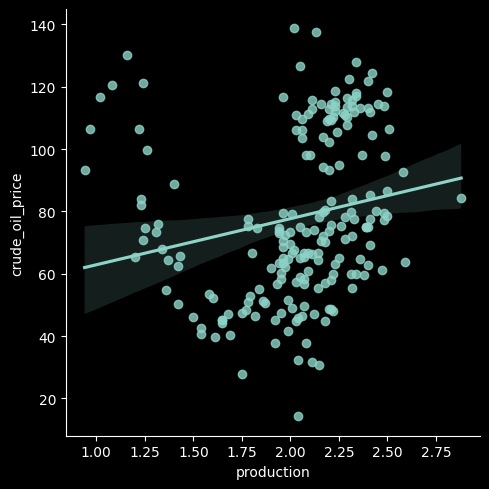

In [36]:
sb.lmplot(data=sqlDF, x= 'production', y='crude_oil_price');

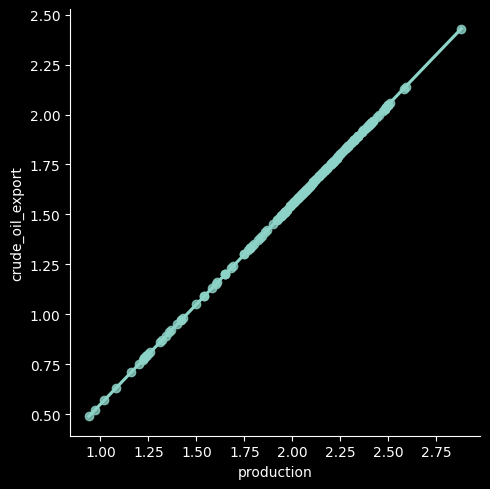

In [37]:
sb.lmplot(data=sqlDF, x= 'production', y='crude_oil_export');

That's interesting! Crude oil price has a perfect positive correlation. Which means we can use just the production column and traiin a model to predict future export of crude oil.

If you want to see this model, do well to follow me as i will be taking my analysis a bit further by build a linear regression model that can predict Nigeria Future Crude Oil Export.

percentage

## Answer to questions
* The largest production was made in October, 2010. A total of 2.88mbd was produced.
* The highest average production of crude oil was made in 2010.
* The highest average price was in year 2011.
* No. On no ocassion has Nigeria exported all its produced crude oil.
* There are 22 count where the crude oil exported fell below 70% of total production.
1. For crude oil price with three years gap, all years are clustered between 35(US$/Barrel) to 84(US$/Barrel) except for year 2012 which had 98.06(US$/Barrel) as it minimum price.
2. For crude oil production with three years gap, production starts falling after year 2012. Year 2021 looks like an outlier because its maximum production, 1.43mbd is way below the minimum, 1.78mbd, of 2018. 

## Summary
* Average price of crude oil increases as the year begins and decrease as the year comes to an end.
* Crude oil price is has been inreasing since 2020, currently (2022) the minimum price per barrel is $88.71 compare to the maximum price of $66.68 in year 2020.
* There has been a decrease in oil production since year 2019. 
* According to [Vanguard news](https://www.vanguardngr.com/2022/04/nigerias-oil-production-rises-5-07-to-1-388mbd-in-q1/) published on April 19, 2022. Nigeria’s failure to boost crude oil production in the face of high price of oil in the international market has been largely blamed on high oil theft and pipeline vandalism in the Niger Delta region. 
* The Group Managing Director of the Nigerian National Petroleum Corporation (NNPC) Limited, Mallam Mele Kyari revealed earlier in April that oil production has crashed to 1.15 million barrels per day. According to him, “As we speak now, there is massive disruption to our operations as a result of the activities of vandals and criminals along our pipelines in the Niger Delta area. This has brought down our production to levels as low as we have never seen before. [Article](https://www.vanguardngr.com/2022/04/nigerias-oil-production-rises-5-07-to-1-388mbd-in-q1/)
* Starting from 2016, the yearly average of crude oil exported has not pass the overall average of crude oil exported.
* The percentage decrease of oil exported in each month of year 2022 compared to months in 2021 is currently above 14%, except for January where ther was 4% increase in exported crude oil.  
* For this sample of data, there is a perfect linear relationship between production and crude oil exported.

## Limitations
* The Dataset consist of few records which starts from 2006 to 2022, this may affects our general view of oil production.
* Our data has few features which is not sufficient enough to depict why there is a fall in oil production.
* Samples for year 2022 is not complete, it stops at september.
* This data did not meet the rule of thumb where at least 100 samples is required for each feature before proceeding to building an algorithm for prediction.

